## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [0]:
np.random.seed(0)

## Generate data

In [4]:
data, labels = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


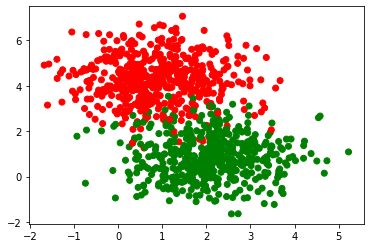

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape,Y_train.shape)

(750, 2) (250, 2) (1000,) (750,)


In [7]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,1)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799]
 [-0.97727788]]


## Weight Vectorised Version

In [0]:
class FF_MultiClass_WeightVectorised:
  
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,1))
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)
  
  def forward_pass(self, x):
    x = x.reshape(1, -1) # (1, 2)
    self.A1 = np.matmul(x,self.W1) + self.B1  # (1, 2) * (2, 2) -> (1, 2)
    self.H1 = self.sigmoid(self.A1) # (1, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (1, 2) * (2, 1) -> (1, 1) 
    self.H2 = self.sigmoid(self.A2) # (1, 1)
    return self.H2
    #((1, 1)
    
    
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def grad(self, x, y):
    self.forward_pass(x)
    x = x.reshape(1, -1) # (1, 2)
    self.dA2=self.H2-y 
    
    self.dW2 = np.matmul(self.H1.T, self.dA2) # (2, 1) * (1, 1) -> (2, 1)
    self.dB2 = self.dA2 # (1, 1)
    self.dH1 = np.matmul(self.dA2, self.W2.T) # (1, 1) * (1, 2) -> (1, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # -> (1, 2)
    
    ##error-> self.dH1 = np.matmul(self.dA2, self.W2.T) # (1, 1) * (1, 2) -> (1, 2)
    #(1, 2) (1, 2) (1, 1) (1, 1)
    self.dW1 = np.matmul(x.T, self.dA1) # (2, 1) * (1, 2) -> (2, 2)
    self.dB1 = self.dA1 # (1, 2)

  
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW1 = np.zeros((2,2))
      dW2 = np.zeros((2,1))
      dB1 = np.zeros((1,2))
      dB2 = np.zeros((1,1))
      for x, y in zip(X, Y):
        self.grad(x, y)
        dW1 += self.dW1
        dW2 += self.dW2
        dB1 += self.dB1
        dB2 += self.dB2  
        
      m = X.shape[0]
      self.W2 -= learning_rate * (dW2/m)
      self.B2 -= learning_rate * (dB2/m)
      self.W1 -= learning_rate * (dW1/m)
      self.B1 -= learning_rate * (dB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
        
    
    if display_loss:
      templist=np.array(loss.values())
      plt.plot(templist)
      plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()

## Input + Weight Vectorised Version

In [0]:
class FF_MultiClass_InputWeightVectorised:
  
  def __init__(self, W1, W2):
    self.W1 = W1.copy()
    self.W2 = W2.copy()
    self.B1 = np.zeros((1,2))
    self.B2 = np.zeros((1,1))
  
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X):
    self.A1 = np.matmul(X,self.W1) + self.B1 # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.sigmoid(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, self.W2) + self.B2 # (N, 2) * (2, 1) -> (N, 1)
    self.H2 = self.sigmoid(self.A2) # (N, 1)
    return self.H2
    
  def grad_sigmoid(self, X):
    return X*(1-X) 
  
  def grad(self, X, Y):
    self.forward_pass(X)
    m = X.shape[0]
    row,column=self.H2.shape
    temp=np.empty([row,column])
    for i in range(row):
      temp[i]=Y[i]
    Y=temp
    self.dA2 = self.H2 - Y # (N, 1) - (N, 1) -> (N, 1)
    
    self.dW2 = np.matmul(self.H1.T, self.dA2) # (2, N) * (N, 1) -> (2, 1)
    self.dB2 = np.sum(self.dA2, axis=0).reshape(1, -1) # (N, 1) -> (1, 1)
    self.dH1 = np.matmul(self.dA2, self.W2.T) # (N, 1) * (1, 2) -> (N, 2)
    self.dA1 = np.multiply(self.dH1, self.grad_sigmoid(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    
    self.dW1 = np.matmul(X.T, self.dA1) # (2, N) * (N, 2) -> (2, 2)
    self.dB1 = np.sum(self.dA1, axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

      
  def fit(self, X, Y, epochs=1, learning_rate=1, display_loss=False):
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      self.grad(X, Y) # X -> (N, 2), Y -> (N, 1)
        
      m = X.shape[0]
      self.W2 -= learning_rate * (self.dW2/m)
      self.B2 -= learning_rate * (self.dB2/m)
      self.W1 -= learning_rate * (self.dW1/m)
      self.B1 -= learning_rate * (self.dB1/m)

      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis=1), Y_pred)
    
    
    if display_loss:
      templist=np.array(loss.values())
      plt.plot(templist)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

## train and evaluation


In [11]:
#models_init = [FF_MultiClass_Scalar(W1, W2), FF_MultiClass_WeightVectorised(W1, W2),FF_MultiClass_InputWeightVectorised(W1, W2)]
models_init = [FF_MultiClass_WeightVectorised(W1, W2),FF_MultiClass_InputWeightVectorised(W1, W2)]

models = []
for idx, model in enumerate(models_init, start=1):
  tic = time.time()
  ffsn_multi_specific = model
  ffsn_multi_specific.fit(X_train,Y_train,epochs=1000,learning_rate=0.1,display_loss=False)
  models.append(ffsn_multi_specific)
  toc = time.time()
  print("Time taken by model {}: {}".format(idx, toc-tic))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Time taken by model 1: 25.68240189552307



Time taken by model 2: 0.6769254207611084


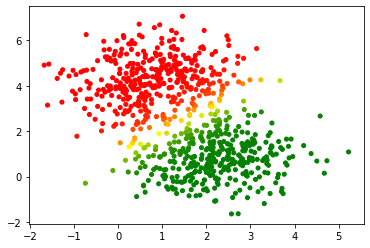

[[117  10]
 [  8 115]]
Model 1
Validation accuracy 0.928


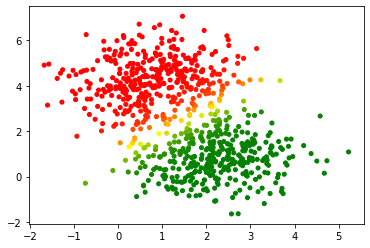

[[117  10]
 [  8 115]]
Model 2
Validation accuracy 0.928


In [12]:
for idx, model in enumerate(models, start=1):
  Y_pred_train = model.predict(X_train)
  plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
  plt.show()
  Y_pred_val = model.predict(X_val)
  Y_pred_val[Y_pred_val>=0.5]=1
  Y_pred_val[Y_pred_val<0.5]=0

  from sklearn.metrics import confusion_matrix 
  cm=confusion_matrix(Y_pred_val,Y_val)
  print(cm)

  accuracy_val = accuracy_score(Y_pred_val, Y_val)
  
  print("Model {}".format(idx))
  
  print("Validation accuracy", accuracy_val)

##original plot

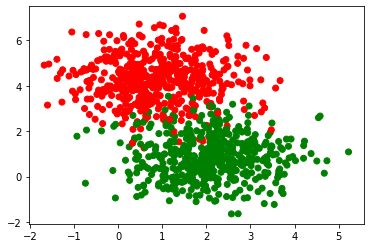

In [13]:

plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Exercises

1. Replicate this vectorisation for the simple first network we saw earlier

2. Extend this vectorisation for the generic feed forward class that we wrote with number of hidden layers and neurons per hidden layer as inputs

3. Understand how the speedup changes as you increase the hidden layers - Keep the number of neurons per layer constant and increase the layers to see how the speed up changes